## Project Overview

This project was a personal project with myself and a friend, wherein we attempted to develop a system that could take a look at all of the economic events of a single type, for example the federal government announcing the interest rate changes, by looking at their history. Then go back and get the price action at the exact time of the release of the event, track what happened in the market (the foreign exchange market or, currency exchange) and then graph those changes in a way that would allow us to make better decisions around those events based on the newly available information.

### Imports, Initializing, and Settings

We have some mostly standard imports except for a few, `glob` is a system module that allows for getting files within a folder, this is necessary to cycle through the events if you wanted to do so. `MetaTrader5` is how the price action data is gathered, it is a connector module that allows access to almost all of the data stored on the MetaTrader account currently logged into on the computer running the script. Finally we have the `IPython-display` module which simple allows for manipulating some aspects of the this notebook within the code, you will see later it is used here to clear outputs.

In [1]:
import os, pandas as pd, glob, MetaTrader5 as mt5, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import timedelta
from IPython.display import clear_output

# This code starts up the MetaTrader software, since it cannot be communicated with while it is dormant.
mt5.initialize()

# These lines somewhat self explanatorily set some visual options for pandas display within jupyter.
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_colwidth', 25)
pd.set_option('display.max_rows', 25)

### Function Definitions

`get_currency list` : this code simply returns the currency pairs that are relevant to a given sector denoted by a 3-letter code. For example, USD will contain all pairs that are directly effected by changes in the US economy, IDX will contain any market indexes, ect. This function is in place to allow quickly switching between what pairs you will want to be looking at for certain economic events. Eg. If you're looking at Australian inflation you won't want to look at USD based indexes and commodities.

In [2]:
def get_currency_list(code):
    switch_dict = {
        'USD': ['EURUSD.p', 'GBPUSD.p', 'AUDUSD.p', 'USDCAD.p', 'USDJPY.p', 'USDCHF.p'],
        'CAD': ['USDCAD.p', 'EURCAD.p', 'GBPCAD.p', 'AUDCAD.p', 'NZDCAD.p', 'CADCHF.p', 'CADJPY.p'],
        'EUR': ['EURUSD.p', 'EURJPY.p', 'EURCAD.p', 'EURGBP.p', 'EURCHF.p', 'EURAUD.p', 'EURNZD.p'],
        'JPY': ['USDJPY.p', 'EURJPY.p', 'GBPJPY.p', 'CADJPY.p', 'CHFJPY.p', 'AUDJPY.p', 'NZDJPY.p'],
        'GBP': ['EURGBP.p', 'GBPUSD.p', 'GBPJPY.p', 'GBPCAD.p', 'GBPCHF.p', 'GBPAUD.p', 'GBPNZD.p'],
        'AUD': ['EURAUD.p', 'GBPAUD.p', 'AUDUSD.p', 'AUDCAD.p', 'AUDJPY.p', 'AUDCHF.p', 'AUDNZD.p'],
        'IDX': ['DJ30.s', 'SP500.s'],
        'CMD': ['UKOUSD.p', 'XAUUSD.p', 'XAGUSD.p']
    }
    
    return switch_dict.get(code, [])

`timeFrameChoice` another simple function to allow quickly choosing between the time frame from which you want to extract data from MetaTrader, it allows for specifying a single numerical value in minutes or hours in place of typing the entire code in the MT5 syntax.

In [3]:
def timeframeChoice(timeframe:int):
    timeframeR = None
    if timeframe == 1:
        timeframeR = mt5.TIMEFRAME_M1
    elif timeframe==5:
        timeframeR = mt5.TIMEFRAME_M5
    elif timeframe==15:
        timeframeR = mt5.TIMEFRAME_M15
    elif timeframe==30:
        timeframeR = mt5.TIMEFRAME_M30
    elif timeframe==60:
        timeframeR = mt5.TIMEFRAME_H1
    elif timeframe==4:
        timeframeR = mt5.TIMEFRAME_H4
    elif timeframe==24:
        timeframeR = mt5.TIMEFRAME_D1
    return timeframeR

`get_price_data` this function executes a call to the MetaTrader software based on the given parameters, such as the time you want the data from and for how long, does some cleaning of unnecessary data from the table object returned by MT5 and then returns the cleaned table as a data frame.

In [4]:
def get_price_data(symbol : str, timeframe : int, start : str, end : str):
# Calls the function described earlier
    tf = timeframeChoice(timeframe)
# Self explanatory
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
# Executes the call to MT5
    rates = mt5.copy_rates_range(symbol, tf, start_date, end_date)   
# Convert to data frame 
    df = pd.DataFrame(rates)
# If data is returned without error, convert time column object type to datetime, and drop unnecessary columns.
    if not df.empty:
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.drop(columns=['tick_volume','real_volume', 'spread'],inplace=True)
    return df

`sell_chart & buy_chart` These two function perform nearly the same task however in the opposite manner, they are almost mirrors of one another except for the fact they deal with different column names. The purpose of these functions is to chart the returned price action data in a 2x2 grid of bar charts, to analyze the economic release from every angle. Each call to these functions represents one bar chart in the grid. For some of the releases a proper bar chart cannot be created since they have continuous values for the X variable of the chart (the difference in release value of the event compared to the projected value by economists) For example, inflation almost always comes out within 0.3% less than or above the expected value, which makes a bar chart with 7 values, however something like new jobs could range thousands or tens of thousands of unique values, so in the situations where this is the case there is code in place within this function to separate the releases into bins and then plot the bins rather than each unique value.

There is also code within this function to plot certain relevant values as text on the chart which will be explained with green text within the code block below.

In [5]:
def sell_chart(dataframe, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4.5))    
# If there is more than 11 unique values for X, then create bins based on groups, and get the mean for each value of each group.
    if len(dataframe["Difference"].value_counts()) > 11:
        avg_neg_change = dataframe.groupby('Groups', observed=False)['max_negative_change'].mean()
        high_before_low = dataframe.groupby('Groups', observed=False)['high_before_low'].mean()
        average_mtl = dataframe.groupby('Groups', observed=False)['minutes_to_low'].mean()    
    # This gathers the count of how many times the economic event fall into each group
        frequency = []
        for k,v in sorted(dataframe['Groups'].value_counts().items()):
            frequency.append(v)

# The same thing as the above code without the need for grouping by the groups.
    else:
        avg_neg_change = dataframe.groupby('Difference', observed=False)['max_negative_change'].mean()
        high_before_low = dataframe.groupby('Difference', observed=False)['high_before_low'].mean()
        average_mtl = dataframe.groupby('Difference', observed=False)['minutes_to_low'].mean() 
        frequency = []
        for k,v in sorted(dataframe['Difference'].value_counts().items()):
            frequency.append(v)

# Create a list containing the bin values as strings in order to supply to the graph's x label later, or in other words,
# this grabs the bin definition as text, for example if a bin is defined as (1, 3] which means all values between 1 and 2.99, this code will
# extract the text of "(1,3]"
    avg_neg_list_keys = []
    for k,v in avg_neg_change.items():
        avg_neg_list_keys.append(str(k).replace("(","").replace("]",""))

# Creates a double bar chart centered on a y value of 0, technically a stacked bar chart, where the bars on the top represents
# the positive change in price (averaged) and the bars on the bottom represent negative change (averaged).
    ax.bar(avg_neg_list_keys,high_before_low.values, color='green', zorder=2)
    ax.bar(avg_neg_list_keys,(avg_neg_change.values)*-1, color='red', zorder=2)

# This code plots text on the chart based on important values to know
    for i, value in enumerate(avg_neg_change.values):
    # This code prints the risk/reward ratio on each bar, or in other words, the R/R given the economic release comes out at that value
    # The if/else part of this code simply checks for a divide by 0 error and if one will arise it prints inf for "infinite" on the chart.
        if avg_neg_change.values[i] != 0 and high_before_low.values[i] != 0:
            ax.text(i, -0.00025, round((avg_neg_change.values[i])/(high_before_low.values[i]), 3), 
                    ha='center', va='top', color='black',rotation = 315, zorder=3)
        else:
            ax.text(i, -0.00025, 'inf', ha='center', va='top', color='black',rotation = 315, zorder=3)
    # This prints the average time it takes for the price action to peak after the release is dropped.
        ax.text(i, 0.00025, f'{int(round(average_mtl.values[i], 0))}m', 
                ha='center', va='top', color='black', zorder=3)

# These two lines print the pearson correlation coefficients for when the difference (actual - expected) of the data release is above or below zero
    ax.text(0.05, 0.05, round(dataframe[dataframe['Difference'] < 0]['Difference'].corr(dataframe[dataframe['Difference'] < 0]['max_negative_change']), 3), 
            transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
    ax.text(0.95, 0.05, round(dataframe[dataframe['Difference'] > 0]['Difference'].corr(dataframe[dataframe['Difference'] > 0]['max_negative_change']), 3), 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
# Plots the text for the bin titles extracted earlier on the chart
    ax.set_xticks(avg_neg_list_keys)
    ax.grid(True, axis='both', linestyle="--", color='grey', zorder=1)
    ax.set_facecolor('#e0e0e0')


# All of the above explanations apply to the following code as well.
def buy_chart(dataframe, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4.5))    
    if len(dataframe["Difference"].value_counts()) > 11:
        avg_pos_change = dataframe.groupby('Groups', observed=False)['max_positive_change'].mean()
        low_before_high = dataframe.groupby('Groups', observed=False)['low_before_high'].mean()
        average_mth = dataframe.groupby('Groups', observed=False)['minutes_to_high'].mean()
        frequency = []
        for k,v in sorted(dataframe['Groups'].value_counts().items()):
            frequency.append(v)

    else:
        avg_pos_change = dataframe.groupby('Difference', observed=False)['max_positive_change'].mean()
        low_before_high = dataframe.groupby('Difference', observed=False)['low_before_high'].mean()
        average_mth = dataframe.groupby('Difference', observed=False)['minutes_to_high'].mean()
        frequency = []
        for k,v in sorted(dataframe['Difference'].value_counts().items()):
            frequency.append(v)

    avg_neg_list_keys = []
    for k,v in avg_pos_change.items():
        avg_neg_list_keys.append(str(k).replace("(","").replace("]",""))

    ax.bar(avg_neg_list_keys,(low_before_high.values)*-1, color='red', zorder=2)
    ax.bar(avg_neg_list_keys,avg_pos_change.values, color='green', zorder=2)
    for i, value in enumerate(avg_pos_change.values):
        if avg_pos_change.values[i] != 0 and low_before_high.values[i] != 0:
            ax.text(i, 0.00025, round((avg_pos_change.values[i])/(low_before_high.values[i]), 3), 
                    ha='center', va='bottom', color='black',rotation = 45, zorder=3)
        else:
            ax.text(i, 0.00025, 'inf', ha='center', va='bottom', color='black',rotation = 45, zorder=3)
        ax.text(i, -0.00025, f'{int(round(average_mth.values[i], 0))}m', 
                ha='center', va='top', color='black', zorder=3)
        
    ax.text(0.05, 0.05, round(dataframe[dataframe['Difference'] < 0]['Difference'].corr(dataframe[dataframe['Difference'] < 0]['max_positive_change']), 3), transform=ax.transAxes,
        horizontalalignment='left', verticalalignment='bottom')
    ax.text(0.95, 0.05, round(dataframe[dataframe['Difference'] > 0]['Difference'].corr(dataframe[dataframe['Difference'] > 0]['max_positive_change']), 3), transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom')
    new_labels = [f"{label} ({freq})" for label, freq in zip(avg_neg_list_keys, frequency)]    
    ax.set_xticks(avg_neg_list_keys)
    ax.set_xticklabels(new_labels, rotation=315)
    ax.grid(True, axis='both', linestyle="--", color='grey', zorder=1)
    ax.set_facecolor('#e0e0e0')

## Main Body

This final section of code ties all of the above sections together, first it searches for the data file of the release, removes the outliers from the dataset, finds the list of pairs based on a given choice to `get_currency_list`, then gathers the data for the first currency pair in a returned list. From there it creates the necessary columns for the charts, then passes the data frame to a 2x2 subplot grid which contains 4 calls to the graph functions, 2 to `buy_chart` and 2 to `sell_chart`. The reason for calling each one twice is that as you will see, a graph for the short term effect (1 hour following release) of the release is given and also the long term effect (8 hours following release) The graph is then displayed and then entire code will run again in a cycle awaiting the user to hit the enter key which will cycle the graph to the next currency pair in the selected list.

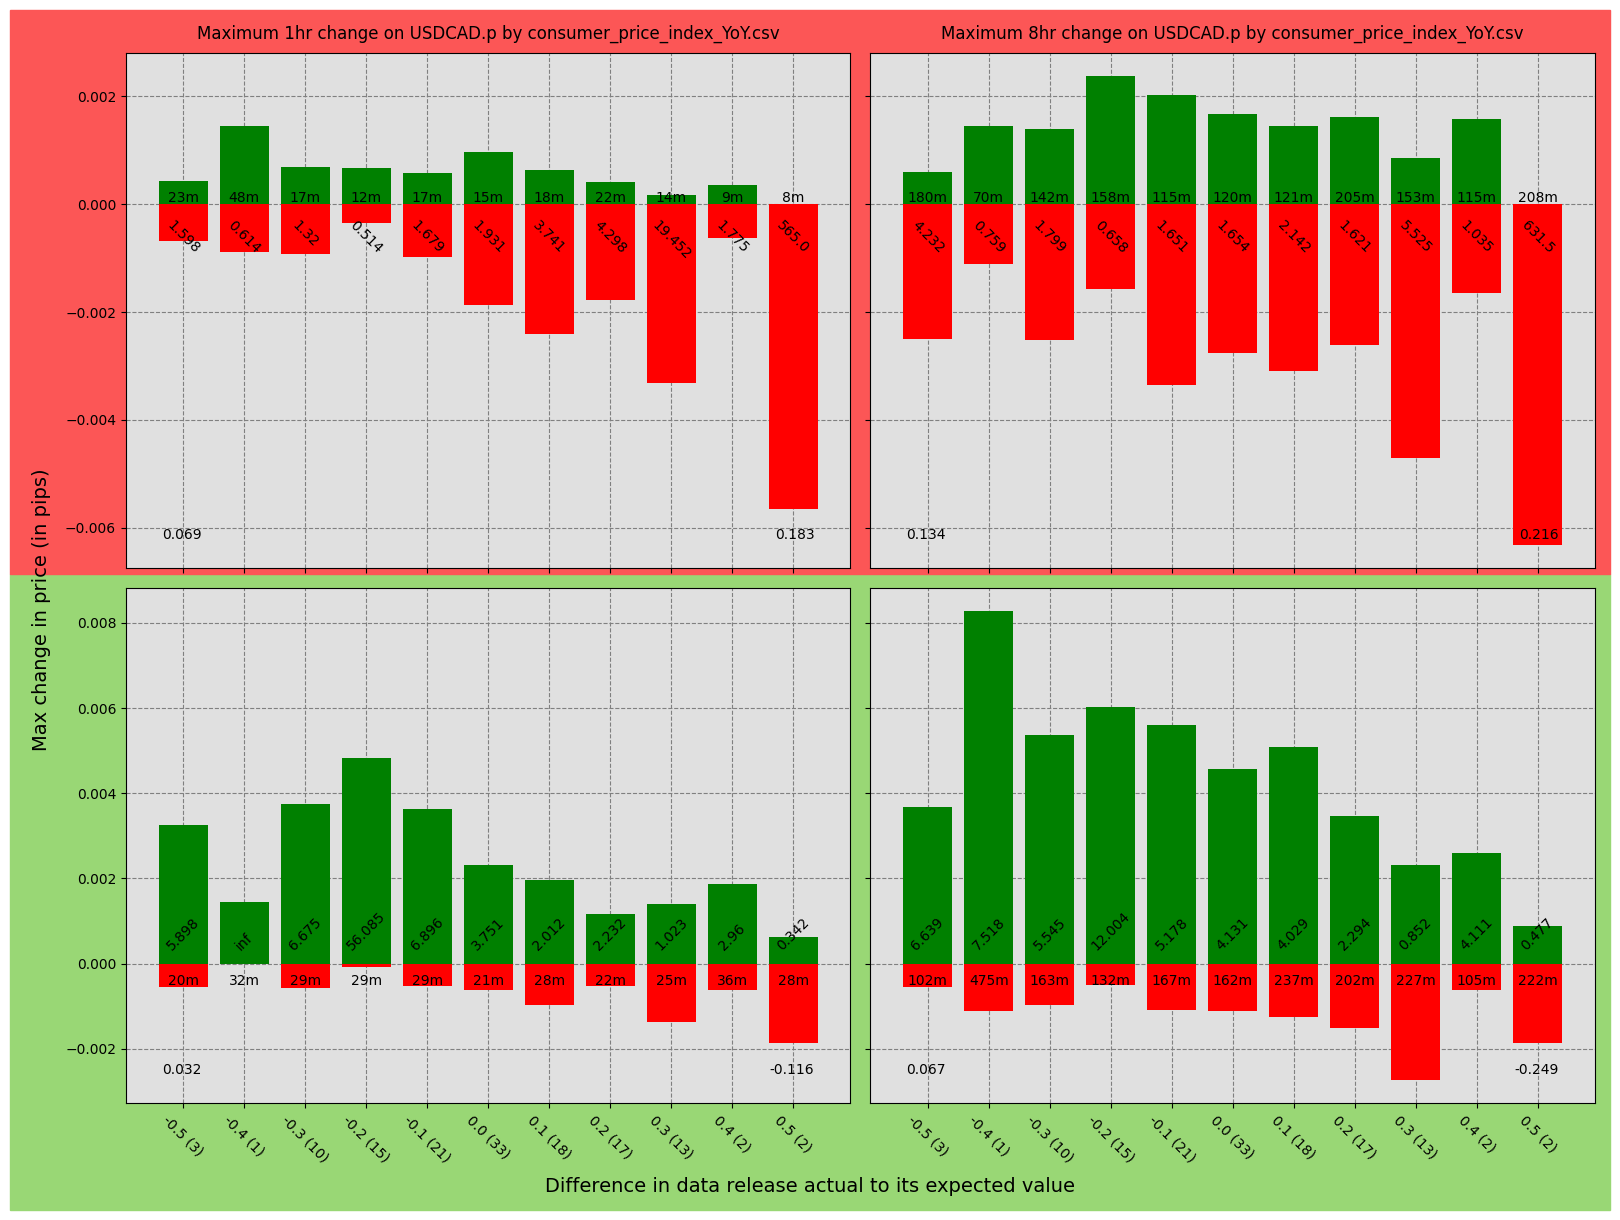

Program quit or no more pairs to analyze, have a good day!


In [6]:
folder_path = r'Data\Canada/*'
# Gets all of the data files (CSVs) within the specified folder.
csv_files = glob.glob(folder_path)
for file in csv_files:
# Grabs the file name from the returned path of the current CSV.
    file_name = os.path.basename(file)
# This if statement is only a way to select data for a certain economic release rather than looking at all of the releases.
    if file_name == 'consumer_price_index_YoY.csv':
        data = pd.read_csv(file, index_col=0, parse_dates=['Date'])
    # Defines and removes outliers from the dataset, since through testing they proved to be problematic.
        outlier_upper_limit = data['Difference'].describe()['mean'] + 2.5*(data['Difference'].describe()['std'])
        outlier_lower_limit = data['Difference'].describe()['mean'] - 2.5*(data['Difference'].describe()['std']) 
        data = data.drop(data[(data['Difference'] > outlier_upper_limit) | (data['Difference'] < outlier_lower_limit)].index)

    # Grabs the list of currency pairs from the our pre-defined function, and iterates through them.
        forex_symbols = get_currency_list('CAD')
        for symbol in forex_symbols:
            data_1hr = data.copy()
            for i, r in data.iterrows():
            # Defines a variable that can add 60 minutes to the returned time of the economic release and then passes both times to the function
            # that communicates with MetaTrader to get data for that hour with the granularity of 1 minute. I.e. a snapshot of the price action
            # is taken every minute and added to a data frame which is returned to our function.
                add_one_hour = timedelta(minutes=60)
                short_term_rates = get_price_data(symbol, 1, r['Date'], r['Date'] + add_one_hour)

            # Here we check if the data frame is valid, or that there is data within it, and if so, we define some variables we will
            # need to create some new columns.
                # if not short_term_rates.empty:
                if True:
                    open = short_term_rates['open'].loc[0]
                    data_1hr.loc[i, 'open'] = open

                # For every instance of an economic event (imagine we have a CSV of USD inflation events and there around 150 events) we
                # calculate the where the price peaked, when it peaked, and how much the difference is between the peak and the starting point
                    max1h = short_term_rates['high'].max()
                    idx_max = short_term_rates['high'].idxmax()
                    max_pos_change_1hr = abs(max1h - open)

                    min1h = short_term_rates['low'].min()
                    idx_min = short_term_rates['low'].idxmin()
                    max_neg_change_1hr = abs(min1h - open)
                    
                # Here some new columns are created in the data set, that iteratively add the calculated fields of the data to an overall
                # data frame. 
                    data_1hr.loc[i, 'max_positive_change'] = max_pos_change_1hr
                    data_1hr.loc[i, 'time_max'] = short_term_rates.loc[short_term_rates['high'] == max1h]['time'].values[0]
                    data_1hr.loc[i, 'minutes_to_high'] = (data_1hr.loc[i, 'time_max'] - r['Date']).total_seconds() / 60
                # This value "low_before_high" is a little tricky to understand, it is the lowest price value before the peak, ONLY if
                # the peak occurred within the first minute of the release dropping. The reason for this is that some of these economic releases
                # can cause extremely volatile changes in the market, and it's possible that within the first minute that the price can peak
                # and then fall below where price opened at in that minute, and since we only have minute by minute snapshots of the data
                # it will appear as though the release is completely unprofitable when in fact if you have a system in place that can
                # automatically make trades then you can capture that initial burst of positive movement (or negative movement for a short trade)
                # so this code simply changes the low before high value in these cases from what could be a large negative one to a moot one.
                    if data_1hr.loc[i, 'minutes_to_high'] == 0 and (max_neg_change_1hr >= 3*max_pos_change_1hr):
                        data_1hr.loc[i, 'low_before_high'] = max_pos_change_1hr
                    else:
                        data_1hr.loc[i, 'low_before_high'] = abs(short_term_rates.loc[:idx_max + 1, 'low'].min() - open)

                # All of these values are mirrors of the ones above, calculating the opposite direction of the trade.
                    data_1hr.loc[i, 'max_negative_change'] = max_neg_change_1hr
                    data_1hr.loc[i, 'time_min'] = short_term_rates.loc[short_term_rates['low'] == min1h]['time'].values[0]
                    data_1hr.loc[i, 'minutes_to_low'] = (data_1hr.loc[i, 'time_min'] - r['Date']).total_seconds() / 60
                    if data_1hr.loc[i, 'minutes_to_low'] == 0 and (max_pos_change_1hr >= 3*max_neg_change_1hr):
                        data_1hr.loc[i, 'high_before_low'] = max_neg_change_1hr
                    else:
                        data_1hr.loc[i, 'high_before_low'] = abs(short_term_rates.loc[:idx_min + 1, 'high'].max() - open)

        # This code creates the groups that are needed to make the bar charts for releases with continuous release values.
        # It does this by splitting the groups using quantiles, centered around 0, since 0 for an economic release generally represents a NULL
        # or unpredictable effect on price action.
            if len(data_1hr["Difference"].value_counts()) > 11:
                bins = [0,0.25,0.50,0.75,1]
                quantiles = []
                for i in bins:
                    quantiles.append(data_1hr[data_1hr['Difference'] < 0]['Difference'].quantile(i))        
                    quantiles.append(data_1hr[data_1hr['Difference'] > 0]['Difference'].quantile(i))
                quantiles.sort()
                data_1hr['Groups'] = pd.cut(data_1hr['Difference'], bins=quantiles, include_lowest=True, right=True,  duplicates='drop')
    

        # All of the above explanations apply to the following section, except the time period in the following code is 8 hours instead of 1.
            data_8hr = data.copy()
            for i, r in data.iterrows():
                add_eight_hours = timedelta(minutes=480)        
                long_term_rates = get_price_data(symbol, 5, r['Date'], r['Date'] + add_eight_hours)

                # if not long_term_rates.empty:
                if True:
                    open = long_term_rates['open'].loc[0]
                    data_8hr.loc[i, 'open'] = open

                    max8h = long_term_rates['high'].max()
                    idx_max = long_term_rates['high'].idxmax()
                    max_pos_change_8hr = abs(max8h - open)

                    min8h = long_term_rates['low'].min()
                    idx_min = long_term_rates['low'].idxmin() 
                    max_neg_change_8hr = abs(min8h - open)           

                    data_8hr.loc[i, 'max_positive_change'] = max_pos_change_8hr
                    data_8hr.loc[i, 'time_max'] = long_term_rates.loc[long_term_rates['high'] == max8h]['time'].values[0]
                    data_8hr.loc[i, 'minutes_to_high'] = (data_8hr.loc[i, 'time_max'] - r['Date']).total_seconds() / 60
                    if data_8hr.loc[i, 'minutes_to_high'] == 0 and (max_neg_change_8hr >= 3*max_pos_change_8hr):
                        data_8hr.loc[i, 'low_before_high'] = max_pos_change_8hr
                    else:
                        data_8hr.loc[i, 'low_before_high'] = abs(long_term_rates.loc[:idx_max + 1, 'low'].min() - open)

                    data_8hr.loc[i, 'max_negative_change'] = max_neg_change_8hr
                    data_8hr.loc[i, 'time_min'] = long_term_rates.loc[long_term_rates['low'] == min8h]['time'].values[0]
                    data_8hr.loc[i, 'minutes_to_low'] = (data_8hr.loc[i, 'time_min'] - r['Date']).total_seconds() / 60
                    if data_8hr.loc[i, 'minutes_to_low'] == 0 and (max_pos_change_8hr >= 3*max_neg_change_8hr):
                        data_8hr.loc[i, 'high_before_low'] = max_neg_change_8hr
                    else:
                        data_8hr.loc[i, 'high_before_low'] = abs(long_term_rates.loc[:idx_min + 1, 'high'].max() - open)     
            
            if len(data_8hr["Difference"].value_counts()) > 11:
                bins = [0,0.25,0.50,0.75,1]
                quantiles = []
                for i in bins:
                    quantiles.append(data_8hr[data_8hr['Difference'] < 0]['Difference'].quantile(i))        
                    quantiles.append(data_8hr[data_8hr['Difference'] > 0]['Difference'].quantile(i))
                quantiles.sort()
                data_8hr['Groups'] = pd.cut(data_8hr['Difference'], bins=quantiles, include_lowest=True, right=True,  duplicates='drop')
            
            
        # The following code is responsible for the creation of the graph and all of its features, the line directly below initializes the graph.
            fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey='row')
        # Here are the previously mentioned calls to the chart functions that retrieve the chart objects and implant them in the subplot
        # at the specified locations.
            sell_chart(data_1hr, ax=axs[0, 0])
            sell_chart(data_8hr, ax=axs[0, 1])
            buy_chart(data_1hr, ax=axs[1, 0])
            buy_chart(data_8hr, ax=axs[1, 1])
        # Here are some titles, two for the columns, one for the x axis and one for the y axis.
            axs[0, 0].set_title('Maximum 1hr change on ' + symbol + ' by ' + file_name, pad=10)
            axs[0, 1].set_title('Maximum 8hr change on ' + symbol + ' by ' + file_name, pad=10)
            fig.text(0.5, 0.02, 'Difference in data release actual to its expected value', ha='center', va='center', fontsize=14)
            fig.text(0.02, 0.5, 'Max change in price (in pips)', ha='center', va='center', rotation='vertical', fontsize=14)
        # The following code defines the center of the subplot object and colors in the background in red for the charts that show shorting
        # potential and green for the charts that show buying potential.
            center_y = axs[0, 0].get_position().y0
            fig.patches.extend([
                Rectangle((0, 0), 1, center_y, color='#99D775', alpha=1, transform=fig.transFigure, zorder=-1),
                Rectangle((0, center_y), 1, 1 - center_y, color='#fc5656', alpha=1, transform=fig.transFigure, zorder=-1)])
            plt.tight_layout(rect=[0.025, 0.025, 1, 1])
            plt.show()
        # This last section of code is what allows for the charts to be cycled from currency to currency instead of just printing all of the charts
        # one after the other such as jupyter would normally do, this code prompts the user for an input, which if nothing is input and
        # just enter is pressed, will cycle once, with the option to type "done" to quit cycling.
            user_choice = input("Hit enter to continue or type \'done\' to quit")
            if user_choice != "" and user_choice.lower()!='done':
                clear_output()
                break
            elif user_choice.lower()=='done':
                break
            clear_output()
        if user_choice.lower() == "done":
                break
# Just prints a nice message but also serves as a confirmation that the code has executed to completion successfully.
print("Program quit or no more pairs to analyze, have a good day!")